In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import autograd.numpy as numpy
import autograd.numpy.random as npr
from sklearn.metrics import accuracy_score, classification_report
from autograd import elementwise_grad
from scipy.optimize import minimize
from tqdm import tqdm 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn import model_selection
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

1.First I standardized the continuous data such as BMI,MentalHealth,PhysicalHealth,etc, and left the binary data alone. Then I handled class imbalance by randomly sampling from the majority class, which was nondiabetic data and dropping those rows. Then I did a logistic regression with the predictors and plotted the ROC curve which has an AUROC score of .82, this means the model is good at separating classes. The precision and recall for both classes are within .04 of each other which indicates that correctly predicted positives and correct positive predictions are about the same and the f_1 for both classes reflects that. Accuracy is similar to precision and recall scores at .74, which means 74 percent of predictions were correct, showing consistent performance. I found the best predictor by shuffling the data for each column and subtracting the new accuracy score with the old to see how much it impacts the model, and general health was the best predictor, with 5 percent decrease in accuracy when it is reordered.  

Accuracy: 0.7442534832732159
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74      7194
           1       0.73      0.77      0.75      6945

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.75      0.74      0.74     14139



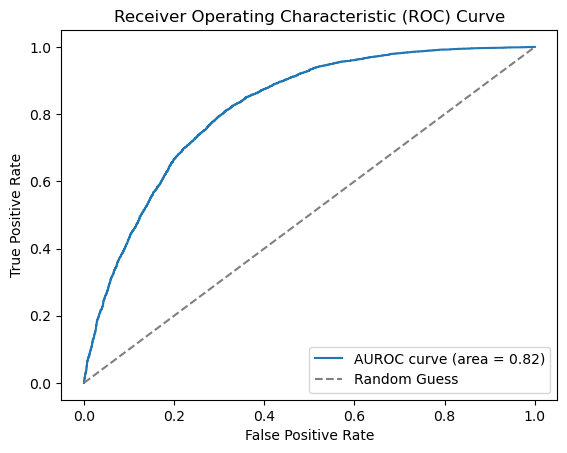

Feature importance ranking:
GeneralHealth: 0.056510361411698184
BMI: 0.030200155597991385
AgeBracket: 0.022986066907136338
HighBP: 0.018601032604851797
HighChol: 0.015347620057995615
HeavyDrinker: 0.0027583280288563383
BiologicalSex: 0.001980338071999488
Myocardial: 0.00176815899285665
IncomeBracket: 0.0012730744748568057
MentalHealth: 0.0006365372374284028
Stroke: 0.0003536317985713966
NotAbleToAffordDoctor: 0.0003536317985713966
Smoker: 0.00021217907914283796
PhysicalHealth: 0.00021217907914283796
HardToClimbStairs: 0.00014145271942855864
Vegetables: 0.0
Zodiac: 0.0
HasHealthcare: -7.072635971427932e-05
PhysActivity: -0.00035363179857128557
EducationBracket: -0.0005658108777141235
Fruit: -0.0007779899568568505


In [17]:
data=pd.read_csv('/Users/marieqi/Downloads/diabetes.csv')
df=data.dropna()
scaler=StandardScaler()
majority_class=df[df['Diabetes']==0]
minority_class=df[df['Diabetes']==1]
num_samples_to_remove=len(majority_class)-len(minority_class)
majority_class_sampled=majority_class.sample(n=num_samples_to_remove,random_state=42)
data_balanced=df.drop(majority_class_sampled.index)
data_balanced=shuffle(data_balanced,random_state=42)
cols=['BMI', 'MentalHealth','PhysicalHealth', 'AgeBracket', 'EducationBracket', 'IncomeBracket', 'Zodiac']
data_balanced[cols]=scaler.fit_transform(data_balanced[cols])
X=data_balanced.iloc[:, 1:]
Y=data_balanced['Diabetes']
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=.2, random_state=42)
x_train=sm.add_constant(X_train)
X_test=sm.add_constant(X_test)
model=LogisticRegression()
model.fit(x_train, Y_train)
y_pred=model.predict(X_test)
y_pred_proba=model.predict_proba(X_test)
accuracy=accuracy_score(Y_test, y_pred)
report=classification_report(Y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
fpr,tpr,thresholds=roc_curve(Y_test, y_pred_proba[:, 1])
roc_auc=roc_auc_score(Y_test, y_pred_proba[:, 1])
plt.plot(fpr, tpr, label=f'AUROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
feature_importance={}
for column in X_train.columns:
    X_val_shuffled=X_test.copy()
    X_val_shuffled[column]=np.random.permutation(X_val_shuffled[column])
    shuffled_score=accuracy_score(Y_test, model.predict(X_val_shuffled))
    feature_importance[column]=accuracy-shuffled_score
sorted_feature_importance=sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("Feature importance ranking:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


2. First I found the optimal slack variable for the LinearSVM using a 10 fold cross validation score to tune C and found that the value of C resulting in highest cv score is 0.001953125, which means the model has high regularization, and favors maximizing margins while creating some inaccurate classifications to improve consistency across different datasets. Then I plotted the ROC curve with a high AUROC score of .82 and accuracy of .7438998514746445, which means 74 percent of points were correctly classified and the AUROC shows the model separates classes much better than random guess and the model performs well. I reduced dimensionality of the 21 features to 2 principal components to plot and visualize the data and hyperplane resulting from linearsvm. 

accuracy  0.7438998514746445


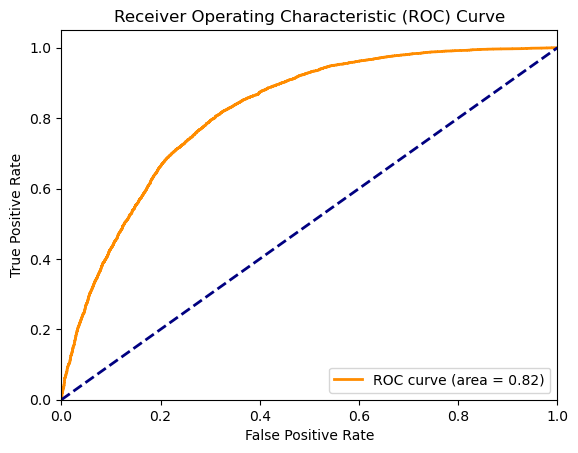

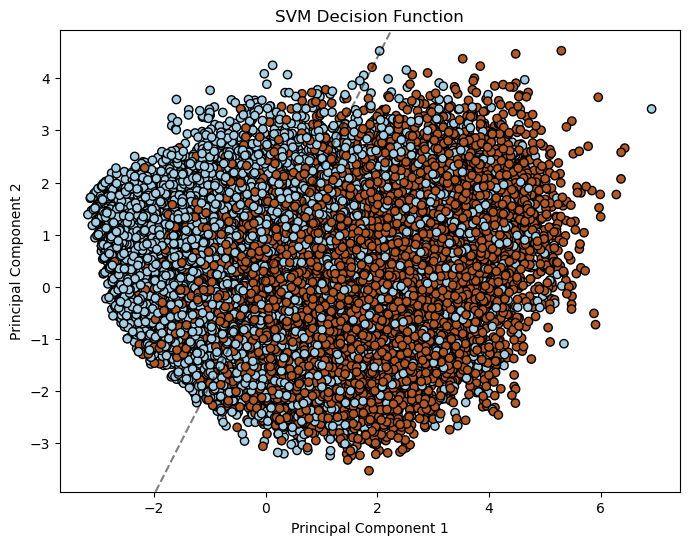

In [38]:
svm_model=LinearSVC(C=0.001953125,dual=False)
svm_model.fit(x_train,Y_train)
y_score=svm_model.decision_function(X_test)
fpr,tpr,thresholds=roc_curve(Y_test, y_score)
roc_auc=auc(fpr, tpr)
pred1=svm_model.predict(X_test)
acc1 = metrics.accuracy_score(Y_test, pred1)
print('accuracy ',acc1)
plt.figure()
plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',lw=2,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

pca=PCA(n_components=2)
X_pca=pca.fit_transform(x_train)
svm_model=SVC(kernel='linear')
svm_model.fit(X_pca, Y_train)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0],X_pca[:, 1], c=Y_train, cmap=plt.cm.Paired, marker='o', edgecolors='k')
ax=plt.gca()
xlim=ax.get_xlim()
ylim=ax.get_ylim()
xx=np.linspace(xlim[0],xlim[1],30)
yy=np.linspace(ylim[0],ylim[1],30)
YY,XX=np.meshgrid(yy, xx)
xy=np.vstack([XX.ravel(),YY.ravel()]).T
Z=svm_model.decision_function(xy).reshape(XX.shape)
ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5, linestyles=['--', '-', '--'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Decision Function')
plt.show()


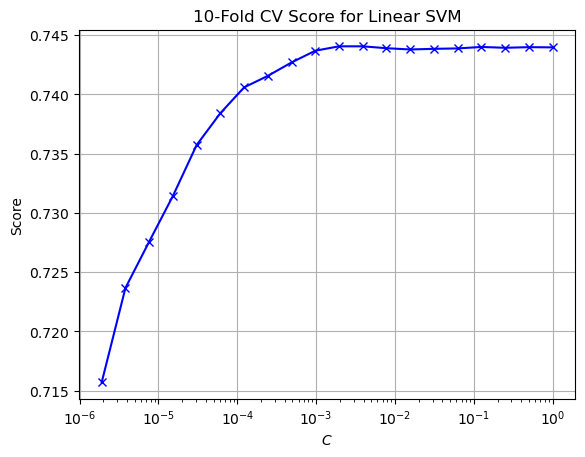

Optimal C: 0.001953125
Max CV Score: 0.74404539298189


In [36]:
#code from lab 4
C_values = 1 / (2 ** np.arange(0, 20))
k = 10 
cv_scores = np.zeros(len(C_values))
split = model_selection.KFold(k)
for i, C in enumerate(C_values):
    svm = LinearSVC(C=C, dual=False)
    cv_scores[i] = np.mean(cross_val_score(svm, X_train, Y_train, cv=split))
optimal_C_index = np.argmax(cv_scores)
optimal_C = C_values[optimal_C_index]
max_cv_score = cv_scores[optimal_C_index]
plt.figure(2)
plt.semilogx(C_values, cv_scores, 'b-x')
plt.xlabel(r'$C$')
plt.ylabel(r'Score')
plt.title(r'{:d}-Fold CV Score for Linear SVM'.format(k))
plt.grid(True);
plt.show()
print("Optimal C:", optimal_C)
print("Max CV Score:", max_cv_score)


3. To use a single decision tree I used sklearn's decision tree classifier and set the criterion to gini so that splitting criterion at each level of the tree is in order of decreasing impurity. The accuracy score was basically the same as the AUROC score of .64, which implies poor ability to distinguish between nondiabetic and diabetic people. Then using the feature importances from the classifier, I get a list of impurity decrease that each feature is responsible for and we get that general health is the best predictor of diabetes with a a importance score of .164, which makes it the best contributor to decreasing gini impurity after each split.

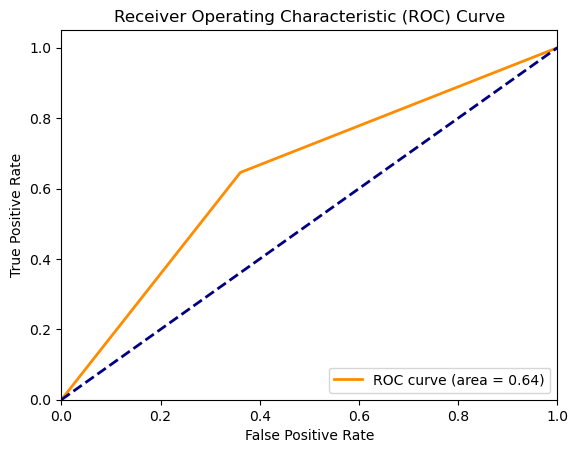

AUROC: 0.642388025138139
accuracy  0.6421953462055308
Feature ranking:
1. Feature GeneralHealth (0.16470427582015823)
2. Feature BMI (0.11770712700894637)
3. Feature Zodiac (0.1163824225526008)
4. Feature AgeBracket (0.08785816544030396)
5. Feature HighBP (0.07902961294487003)
6. Feature IncomeBracket (0.07100683999488783)
7. Feature PhysicalHealth (0.057870364568239914)
8. Feature EducationBracket (0.05357256751360653)
9. Feature MentalHealth (0.048461211172310836)
10. Feature Smoker (0.028339892203051966)
11. Feature Fruit (0.025237373945912845)
12. Feature PhysActivity (0.02217206953677242)
13. Feature BiologicalSex (0.022097075606633734)
14. Feature HighChol (0.02131273625747236)
15. Feature Vegetables (0.02001678091852911)
16. Feature HardToClimbStairs (0.01586236229744382)
17. Feature Myocardial (0.014303301492469242)
18. Feature NotAbleToAffordDoctor (0.009872585378139972)
19. Feature Stroke (0.009450492163144503)
20. Feature HeavyDrinker (0.008207306453180357)
21. Feature HasHe

In [64]:
clf = tree.DecisionTreeClassifier(criterion='gini')
clf = clf.fit(x_train, Y_train)
preds=clf.predict(X_test)
probas=clf.predict_proba(X_test)
fpr,tpr,thresholds=roc_curve(Y_test, probas[:, 1])
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
print("AUROC:", roc_auc)
print("accuracy ",np.sum(preds == Y_test)/len(preds))
importances=clf.feature_importances_
indices=np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {df.columns[indices[f]]} ({importances[indices[f]]})")

4. First I tune the hyperparameter n_estimators which is the number of weak learners in our RandomForestClassifier, and using gridsearch I get an optimal n of 1000, and compared to the single decision tree, the AUROC score is .82 and accuracy is about .75, which is a big improvement. The optimal n shows that 1000 weak learners are needed to get the final model to our accuracy of .75, since tuning comes from bootstrapping and feature subsampling, model variance decreases as we add more indpendent weak learners, however taking into account decreasing returns, the model will become less and less sensitive the more trees we add so I settled on 1000 to save runtime. Using the importance scores from RandomForestClassifier, the best predictor is BMI, which means it is the feature that accounted for the average highest decrease in impurity across 1000 learners.

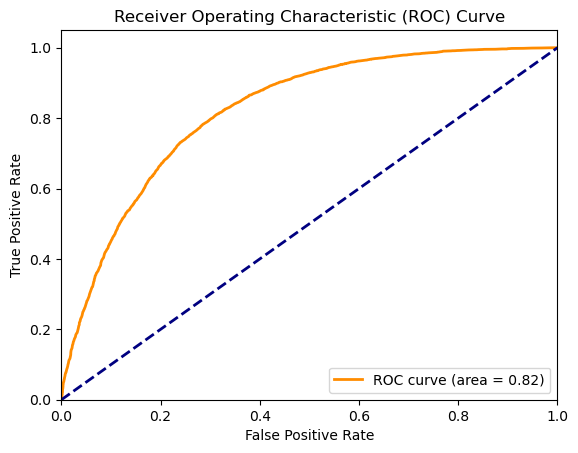

AUROC: 0.8209463309657495
accuracy: 0.7472947167409294
Feature ranking:
1. Feature BMI (0.13962471207260174)
2. Feature GeneralHealth (0.1286491330372545)
3. Feature AgeBracket (0.10550550015320334)
4. Feature Zodiac (0.09837956403244456)
5. Feature HighBP (0.09336095795801623)
6. Feature IncomeBracket (0.07077328896040273)
7. Feature PhysicalHealth (0.05485830502019041)
8. Feature EducationBracket (0.048350999938084074)
9. Feature MentalHealth (0.04378404623135384)
10. Feature HighChol (0.0349625294216725)
11. Feature BiologicalSex (0.024331066098267063)
12. Feature Smoker (0.024208019281869313)
13. Feature Fruit (0.023456523614490955)
14. Feature PhysActivity (0.02072012143934114)
15. Feature HardToClimbStairs (0.019259740554702944)
16. Feature Vegetables (0.018708236211636253)
17. Feature Myocardial (0.016711782281051094)
18. Feature NotAbleToAffordDoctor (0.009799791157798984)
19. Feature Stroke (0.009074768918162033)
20. Feature HeavyDrinker (0.008979761578305746)
21. Feature HasH

In [66]:
clf= RandomForestClassifier(n_estimators=1000,max_samples=0.1, max_features=0.5,bootstrap=True, criterion='gini')
clf.fit(x_train,Y_train)
preds = clf.predict(X_test)
probas=clf.predict_proba(X_test)
fpr,tpr,thresholds=roc_curve(Y_test, probas[:, 1])
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
print("AUROC:", roc_auc)
print('accuracy:', np.sum(preds == Y_test)/len(preds))
importances=clf.feature_importances_
indices=np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {df.columns[indices[f]]} ({importances[indices[f]]})")

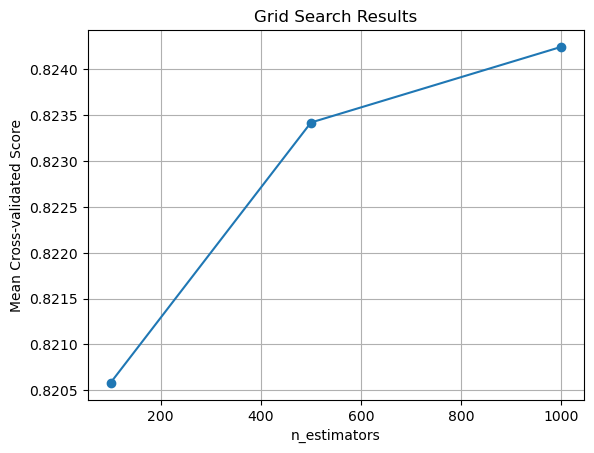

Best Parameters: {'n_estimators': 1000}
Best Score: 0.8242468182330519


In [62]:
clf=RandomForestClassifier(max_samples=0.1, max_features=0.5,bootstrap=True, criterion='gini')
params={'n_estimators': [100,500,1000]}
grid_search=GridSearchCV(estimator=clf, param_grid=params, scoring='roc_auc', cv=5)
grid_search.fit(x_train, Y_train)
param_values = grid_search.cv_results_['param_n_estimators']
mean_scores = grid_search.cv_results_['mean_test_score']
plt.figure()
plt.plot(param_values, mean_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Cross-validated Score')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

5. First I tuned the hyperparameters of learning rate and n_estimators, using the AUROC as the metric for cross validation, and found the maximum cv scores occured at 100 estimators and .5 learning rate, meaning 100 weak learners with a moderate influence on the final classification. The learning rate of .5 balances training speed and overfitting risk so our convergence speed is average and our model's sensitivity to each iteration is average as well in this trade off. Our model reaches the final AUROC of .82, which shows good classification ability. The best predictor for this model is Agebracket, which means it leads to the largest decrease in weighted error rate out of all features after each boosting iteration.

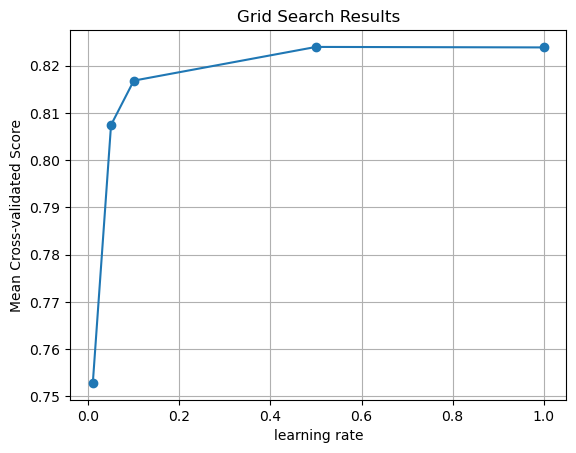

Best parameters: {'learning_rate': 0.5}
Best cross-validation score: 0.8239573094960673


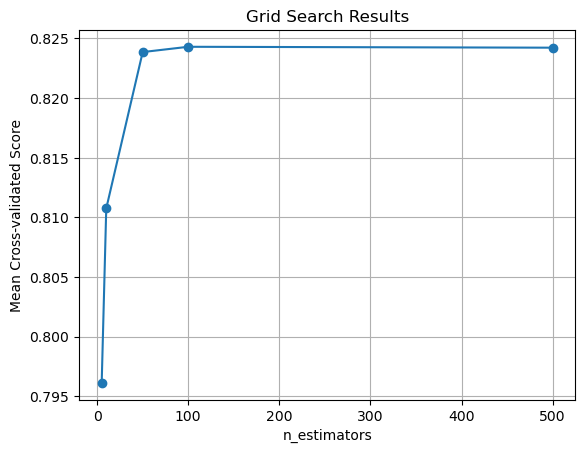

Best Parameters: {'n_estimators': 100}
Best Score: 0.8242956335695645


In [71]:
adaboost_clf = AdaBoostClassifier()
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]}
grid_search = GridSearchCV(adaboost_clf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(x_train, Y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
param_values = grid_search.cv_results_['param_learning_rate']
mean_scores = grid_search.cv_results_['mean_test_score']
plt.figure()
plt.plot(param_values, mean_scores, marker='o')
plt.xlabel('learning rate')
plt.ylabel('Mean Cross-validated Score')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()
print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)
params={'n_estimators': [5,10,50,100,500]}
grid_search=GridSearchCV(estimator=adaboost_clf, param_grid=params, scoring='roc_auc', cv=5)
grid_search.fit(x_train, Y_train)
param_values = grid_search.cv_results_['param_n_estimators']
mean_scores = grid_search.cv_results_['mean_test_score']
plt.figure()
plt.plot(param_values, mean_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Cross-validated Score')
plt.title('Grid Search Results')
plt.grid(True)
plt.show()
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

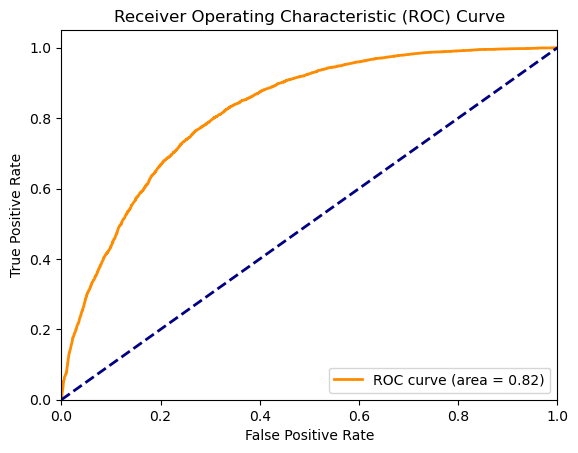

AUROC: 0.8200874138576003
accuracy: 0.7456680104675012
Feature ranking:
1. Feature AgeBracket (0.2566706169801172)
2. Feature GeneralHealth (0.24448082404431906)
3. Feature BMI (0.158704701679389)
4. Feature HeavyDrinker (0.10105372528073964)
5. Feature HighBP (0.08113235449887315)
6. Feature HighChol (0.061192677079125436)
7. Feature IncomeBracket (0.04192905269438499)
8. Feature Myocardial (0.022569298806799743)
9. Feature BiologicalSex (0.021626206966913145)
10. Feature HardToClimbStairs (0.010640541969338438)
11. Feature PhysActivity (0.0)
12. Feature Smoker (0.0)
13. Feature Stroke (0.0)
14. Feature Zodiac (0.0)
15. Feature Fruit (0.0)
16. Feature Vegetables (0.0)
17. Feature HasHealthcare (0.0)
18. Feature NotAbleToAffordDoctor (0.0)
19. Feature MentalHealth (0.0)
20. Feature PhysicalHealth (0.0)
21. Feature EducationBracket (0.0)


In [72]:
bdt = AdaBoostClassifier(
    tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=100, learning_rate=.5
)
bdt.fit(x_train, Y_train)
preds = bdt.predict(X_test)
probas=bdt.predict_proba(X_test)
fpr,tpr,thresholds=roc_curve(Y_test, probas[:, 1])
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
print("AUROC:", roc_auc)
print('accuracy:', np.sum(preds == Y_test)/len(preds))
importances=bdt.feature_importances_
indices=np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {df.columns[indices[f]]} ({importances[indices[f]]})")